## Part 1: Database Design and ETL Pipeline

### Extract: Read all three CSV files
### Transform:
- Remove duplicate records
- Handle missing values (use appropriate strategy: drop, fill, or default)
- Standardize phone formats (e.g., +91-9876543210)
- Standardize category names (e.g., "electronics", "Electronics", "ELECTRONICS" → "Electronics")
- Convert date formats to YYYY-MM-DD
- Add surrogate keys (auto-incrementing IDs)

In [1]:
# Imports needed

import pandas as pd
import numpy as np
import phonenumbers
import os
import pathlib
import mysql.connector
from dotenv import load_dotenv

#Path setup
current_path = pathlib.Path.cwd()
os.chdir(current_path /'data')

In [2]:
# Read raw data

def read_raw_data(file_name):

    return pd.read_csv(file_name)
    

In [3]:
#Data Quality Report
data_quality_report = []

# Function to check and handling missing value in the columns of the dataframe
def find_treat_missing_val(df: pd.DataFrame):

    df = df.copy()

    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

    missing_summary = []

    for col, cnt in df.isna().sum().items():
        if cnt > 0:
            missing_summary.append(f"{col}: {cnt}")
            if col in numeric_cols:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna('Unknown')

    # Handle date column
    dte_col = df.columns[df.columns.str.contains('date', case=False)]
    if len(dte_col) > 0:
        df.loc[:, dte_col[0]] = pd.to_datetime(
            df[dte_col[0]],
            format='mixed',
            errors="coerce"
        ).dt.strftime("%Y-%m-%d")

    transform_df = df.drop_duplicates().copy()

    data_quality_report.append({
        'Record Count': len(df),
        'Duplicate Rows': int(df.duplicated().sum()),
        'Null Count': ", ".join(missing_summary) if missing_summary else "No Nulls",
        'Insert Count': len(transform_df)
    })

    
    
    return transform_df, data_quality_report

## Inserting the data to the MYSQL database tables

In [4]:
# Upload data to MySQL Database
def upload_data_db(df: pd.DataFrame, table_name):

    load_dotenv()
    conn = mysql.connector.Connect(
    host = os.getenv('MYSQL_HOST_URL'),
    user = os.getenv('MYSQL_USER'),
    password = os.getenv('MYSQL_PWD'),
    database = os.getenv('MYSQL_DB')
    )

    cursor = conn.cursor()

    cols_names = ",".join(df.columns)
    placeholder = ",".join(["%s"] * len(df.columns))
    update_clause = ",".join(
        [f"{col}=VALUES({col})" for col in df.columns if col != 'customer_id']  
    )

    sql = f"""
    INSERT INTO {table_name} ({cols_names})
    VALUES ({placeholder})
    ON DUPLICATE KEY UPDATE
    {update_clause}
    """

    cursor.executemany(sql, df.values.tolist())

    conn.commit()

    cursor.close()
    conn.close()    

### Customer Data

In [5]:
# Generate Data Quality Report in TXT format
from datetime import datetime

def generate_data_quality_report_txt(report, file_name="data_quality_report.txt"):
    with open(file_name, "w") as f:
        f.write("DATA QUALITY REPORT\n")
        f.write("=" * 60 + "\n")
        f.write(f"Generated On: {datetime.now()}\n\n")

        for idx, row in enumerate(report, start=1):
            f.write(f"Dataset #{idx}\n")
            f.write(f"Records Processed      : {row['Record Count']}\n")
            f.write(f"Duplicates Removed     : {row['Duplicate Rows']}\n")
            f.write(f"Missing Values Handled : {row['Null Count']}\n")
            f.write(f"Records Loaded         : {row['Insert Count']}\n")
            f.write("-" * 60 + "\n")

cust_df = read_raw_data('customers_raw.csv')

cust_df_clean, dq_report = find_treat_missing_val(cust_df)

#phone number formatting
cust_df_clean.loc[:, 'phone'] = cust_df_clean['phone'].apply(
    lambda x: phonenumbers.format_number(
        phonenumbers.parse(str(x), region='IN'),
        phonenumbers.PhoneNumberFormat.E164
    ) if pd.notna(x) else None
)

#customer_id formatting
cust_df_clean.loc[:, 'customer_id'] = (
    cust_df_clean['customer_id']
    .astype(str)
    .str.replace(r'\D+', '', regex=True)
)

#Remove duplicates before uploading to DB
cust_df_clean = cust_df_clean.drop_duplicates(
    subset='customer_id',
    keep='first'
)

#upload to DB
upload_data_db(cust_df_clean,'customers')
cust_df_clean.head()

,customer_id,first_name,last_name,email,phone,city,registration_date
0,001,Rahul,Sharma,rahul.sharma@gmail.com,+919876543210,Bangalore,2023-01-15
1,002,Priya,Patel,priya.patel@yahoo.com,+919988776655,Mumbai,2023-02-20
2,003,Amit,Kumar,Unknown,+919765432109,Delhi,2023-03-10
3,004,Sneha,Reddy,sneha.reddy@gmail.com,+919123456789,Hyderabad,2023-04-15
4,005,Vikram,Singh,vikram.singh@outlook.com,+919988112233,Chennai,2023-05-22


![alt text](customers.png)

### Product 

In [6]:
prod_df = read_raw_data('products_raw.csv')
prod_df_clean, dq_report = find_treat_missing_val(prod_df)
prod_df_clean['product_id'] = prod_df_clean['product_id'].astype(str).str.replace(r'\D+', '', regex=True)
prod_df_clean['category'] = prod_df_clean['category'].str.title()
upload_data_db(prod_df_clean,'products')
prod_df_clean.head()

,product_id,product_name,category,price,stock_quantity
0,001,Samsung Galaxy S21,Electronics,45999.0,150.0
1,002,Nike Running Shoes,Fashion,3499.0,80.0
2,003,Apple MacBook Pro,Electronics,2999.0,45.0
3,004,Levi's Jeans,Fashion,2999.0,120.0
4,005,Sony Headphones,Electronics,1999.0,200.0


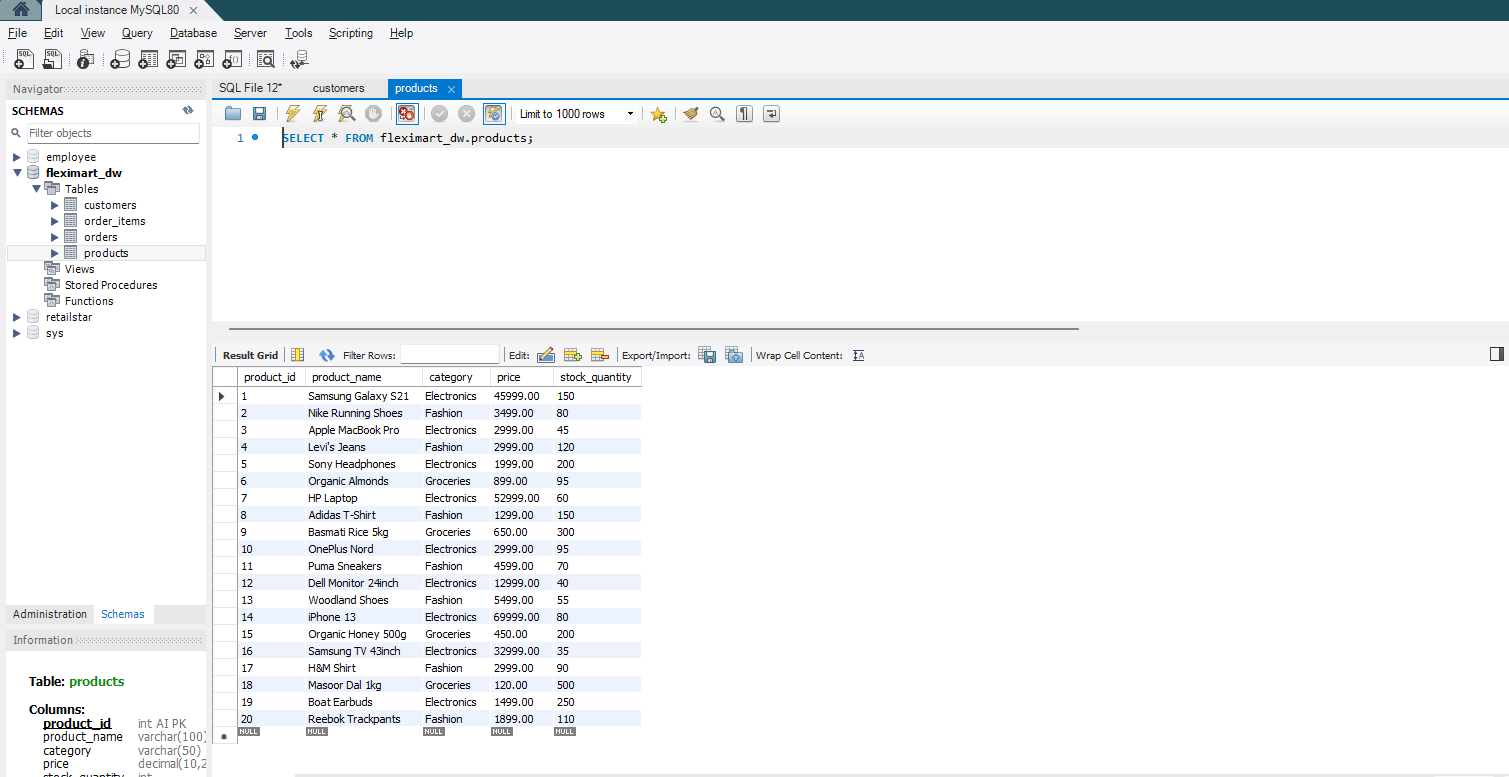

### Transcation Data

In [7]:
sales_df = read_raw_data('sales_raw.csv')
sales_df_clean, dq_report = find_treat_missing_val(sales_df)



sales_df_clean = sales_df_clean[~sales_df_clean.eq('Unknown').any(axis=1)]

sales_df_clean['total_amount'] = sales_df_clean['quantity'] * sales_df_clean['unit_price'] 
sales_df_clean[['transaction_id', 'customer_id','product_id']] = sales_df_clean[['transaction_id', 'customer_id','product_id']].astype(str).apply(lambda s:s.str.replace(r'\D+', '', regex=True))
sales_df_clean.rename(columns={'transaction_id': 'order_id','transaction_date':'order_date'}, inplace=True)

In [8]:
upload_data_db(sales_df_clean[['order_id','customer_id','order_date','total_amount','status']],'orders')
upload_data_db(sales_df_clean[['product_id','order_id','quantity','unit_price']],'order_items')
sales_df_clean.head()

,order_id,customer_id,product_id,quantity,unit_price,order_date,status,total_amount
0,001,001,001,1,45999.0,2024-01-15,Completed,45999.0
1,002,002,004,2,2999.0,2024-01-16,Completed,5998.0
2,003,003,007,1,52999.0,2024-01-15,Completed,52999.0
4,005,005,009,3,650.0,2024-01-20,Completed,1950.0
5,006,006,012,1,12999.0,2024-01-22,Completed,12999.0


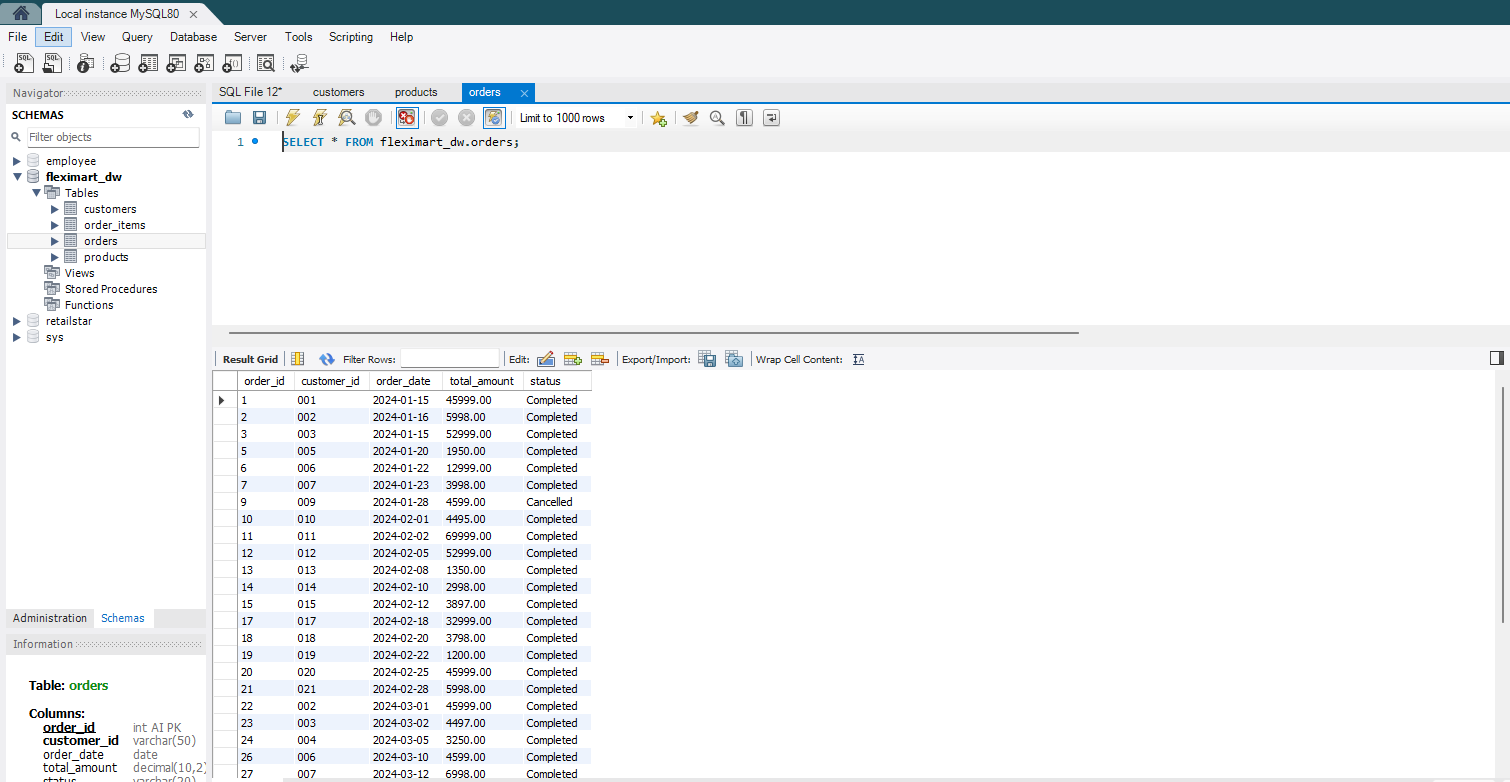

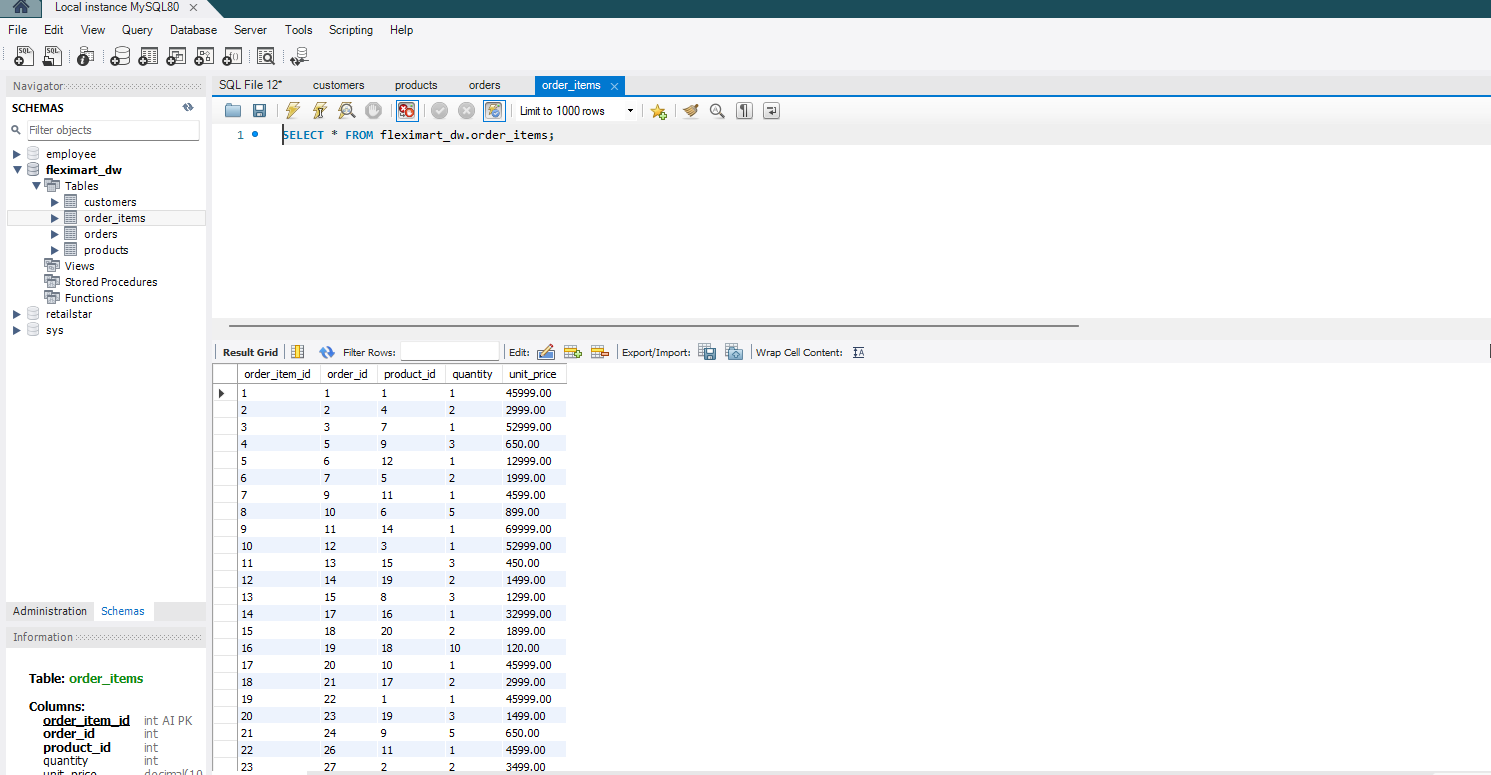

### Data Quality Report

In [9]:
pd.DataFrame(data_quality_report)

,Record Count,Duplicate Rows,Null Count,Insert Count
0,26,1,email: 5,25
1,20,0,"price: 3, stock_quantity: 1",20
2,41,1,"customer_id: 3, product_id: 2",40


In [10]:
generate_data_quality_report_txt(data_quality_report)